# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [16]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
import numpy as np
import pandas as pd

In [18]:
bike = pd.read_csv("day.csv")

In [19]:
# Check the head of the dataset
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Inspect the various aspects of the housing dataframe

In [20]:
bike.shape
# Inference - 730 Rows, 16 Columns

(730, 16)

In [21]:
bike.info()
# Inference - no null values. Imputing not needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [22]:
bike.describe()
# Inference 
# - Scaling needed for  temp, atemp, him, windspeed
# - Should holiday and weekday be converted to categorical and then to dummy variables?

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


Drop unnecessary columns
- instant - just index
- dteday - yr and month are available in separate columns, so not needed
- casual, registered - total count given by cnt column makes more sense than the casual and registered columns.

In [23]:
columns = ['instant','dteday','casual','registered']
bike = bike.drop(columns, axis=1)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


Check for duplicates

In [9]:
bike_dup = bike.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)
bike_dup.shape
# Inference
# - same value as original dataframe. So no duplicates.

(730, 12)

## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot numeric variables

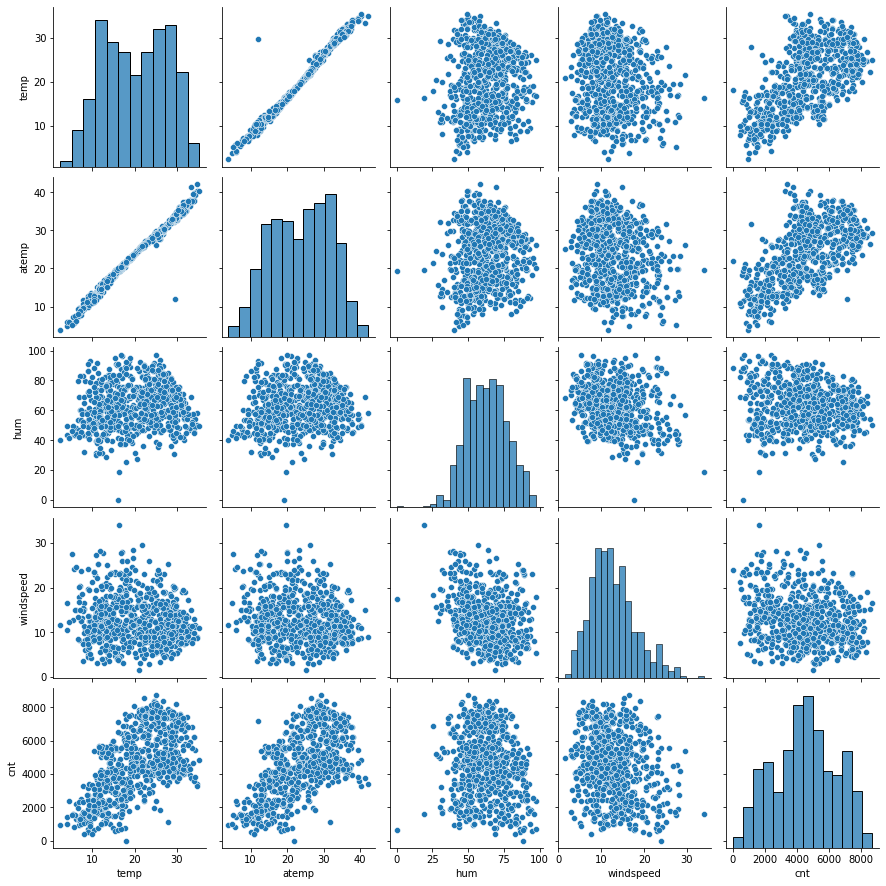

In [25]:
# pick only the relevant numeric variables and check
bike_num=bike[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sns.pairplot(bike_num)
plt.show()

Inference
- The pair plots tells us that there is a linear relationship between 
  - atemp and temp
  - atemp and cnt
  - temp and cnt

Plot categorical variables

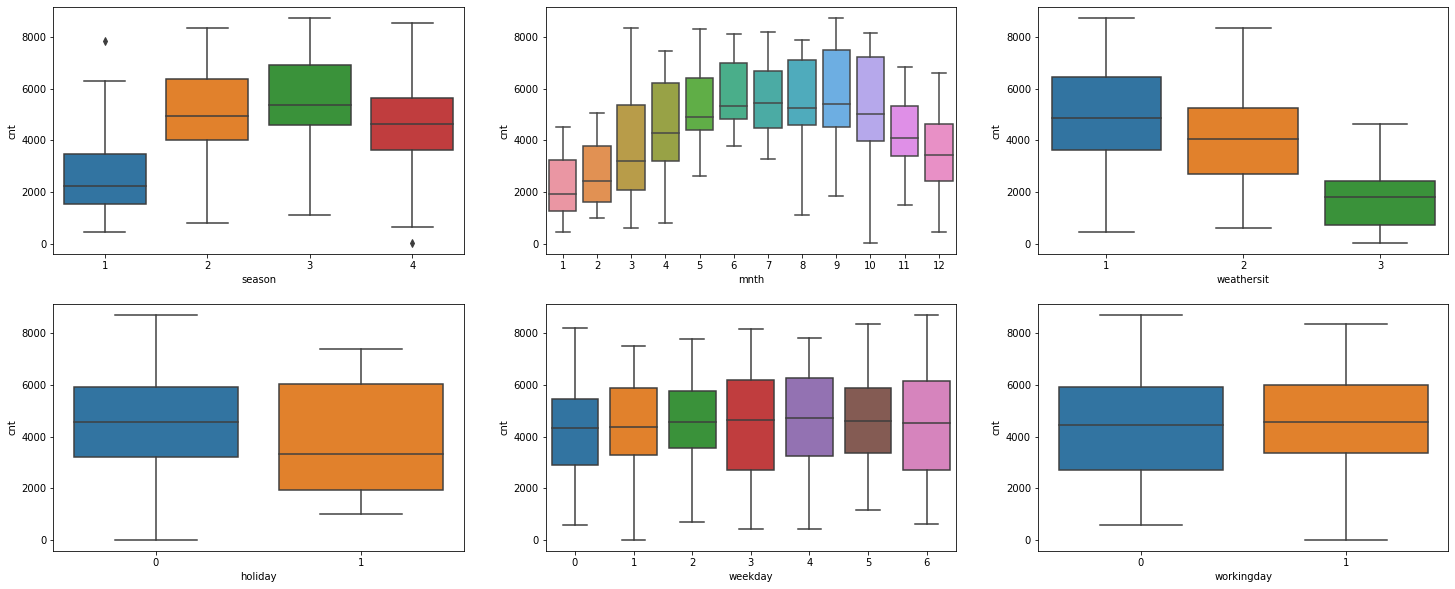

In [26]:
# Build boxplot of all categorical variables (before creating dummies) againt the target variable 'cnt' 

plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.show()

Inference
- Season
  - Season3 has the most bookings with highest median around 5000
  - It is clear that season affects the count. Hence it could be a predictor.
- Month
  - Mnth9 has the maximum bookings with a median of 5000
  - It is clear that mnth affects the count. Hence it could be a predictor.

Create dummy variables for categorical data
- Some columns like weathersit, season, month, weekday seem to be categorical but have int/float values

In [10]:
# check types
# Check the datatypes before convertion
bike.info()
# Inference
# mnth is int64
# weekday is int64
# weathersit is int64
# season is int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


Convert weathersit and season to categorical variables

In [11]:
# convert weathersit and season to actual string values from data dictionary
weathersit={1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'}
season={1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
bike['weathersit']=bike['weathersit'].replace(weathersit)
bike['season']=bike['season'].replace(season)
bike.head()
bike.info()

# inference - type has changed to object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 68.6+ KB


Do Type Conversion of mnth and weekday

In [12]:
bike['mnth']=bike['mnth'].astype('category')
bike['weekday']=bike['weekday'].astype('category')
# check types
bike.info()
# inference - type has changed to category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    object  
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    object  
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(2), float64(4), int64(4), object(2)
memory usage: 59.3+ KB


Get dummies and remove source columns for weathersit,season,mnt, weekday

In [13]:
bike = pd.get_dummies(bike, drop_first=True)
bike.info()
print(bike.shape)
# inference
# created dummies for categorical variables
# - # of columns increased to 30

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   atemp                  730 non-null    float64
 5   hum                    730 non-null    float64
 6   windspeed              730 non-null    float64
 7   cnt                    730 non-null    int64  
 8   season_Spring          730 non-null    uint8  
 9   season_Summer          730 non-null    uint8  
 10  season_Winter          730 non-null    uint8  
 11  mnth_2                 730 non-null    uint8  
 12  mnth_3                 730 non-null    uint8  
 13  mnth_4                 730 non-null    uint8  
 14  mnth_5                 730 non-null    uint8  
 15  mnth_6

Standardize temp, atemp, humidity, windspeed

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

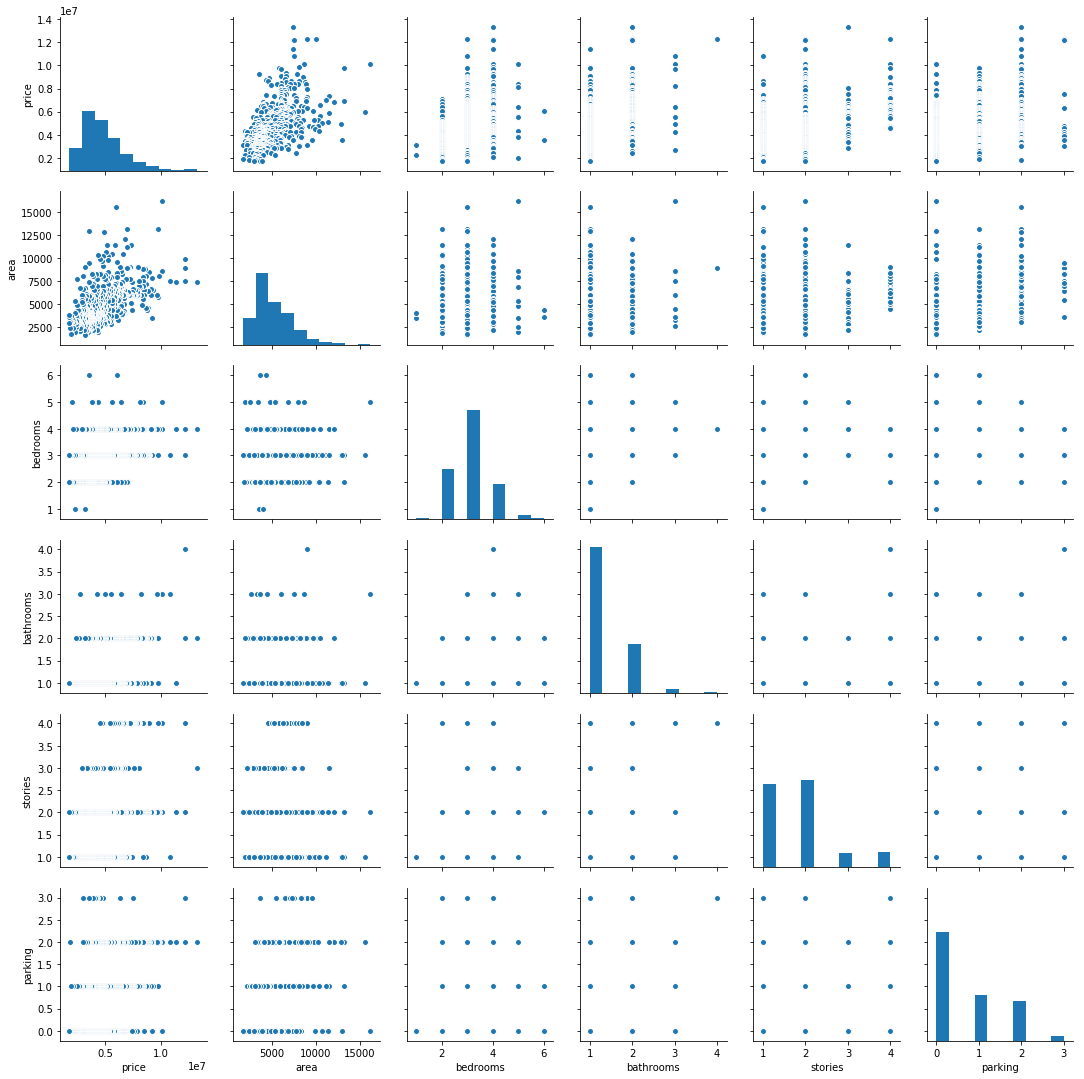

In [ ]:
sns.pairplot(bike)
plt.show()

#### Visualising Categorical Variables

As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

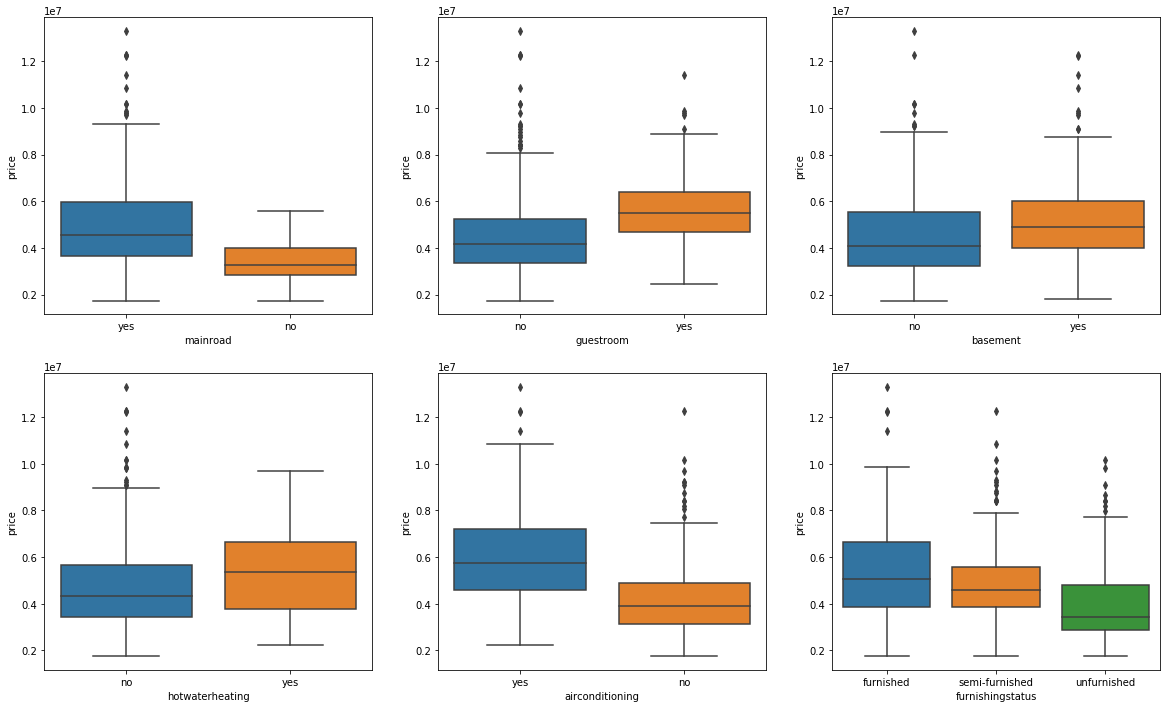

In [ ]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'mainroad', y = 'price', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'guestroom', y = 'price', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'basement', y = 'price', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'hotwaterheating', y = 'price', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'airconditioning', y = 'price', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'furnishingstatus', y = 'price', data = housing)
plt.show()

We can also visualise some of these categorical features parallely by using the `hue` argument. Below is the plot for `furnishingstatus` with `airconditioning` as the hue.

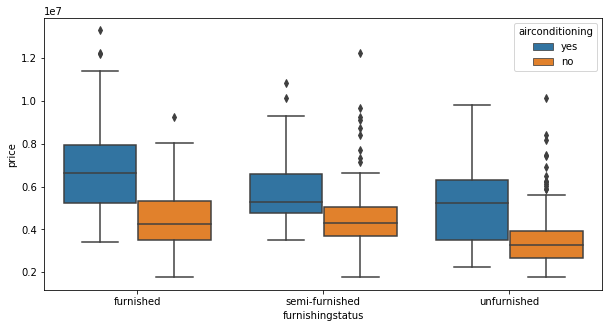

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'furnishingstatus', y = 'price', hue = 'airconditioning', data = housing)
plt.show()

## Step 3: Data Preparation

- You can see that your dataset has many columns with values as 'Yes' or 'No'.

- But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s, where 1 is a 'Yes' and 0 is a 'No'.

In [ ]:
# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)

In [ ]:
# Check the housing dataframe now

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Dummy Variables

The variable `furnishingstatus` has three levels. We need to convert these levels into integer as well. 

For this, we will use something called `dummy variables`.

In [ ]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a new variable - 'status'
status = pd.get_dummies(housing['furnishingstatus'])

In [ ]:
# Check what the dataset 'status' looks like
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Now, you don't need three columns. You can drop the `furnished` column, as the type of furnishing can be identified with just the last two columns where — 
- `00` will correspond to `furnished`
- `01` will correspond to `unfurnished`
- `10` will correspond to `semi-furnished`

In [ ]:
# Let's drop the first column from status df using 'drop_first = True'

status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)

In [ ]:
# Add the results to the original housing dataframe

housing = pd.concat([housing, status], axis = 1)

In [ ]:
# Now let's see the head of our dataframe.

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [ ]:
# Drop 'furnishingstatus' as we have created the dummies for it

housing.drop(['furnishingstatus'], axis = 1, inplace = True)

In [ ]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [ ]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [ ]:
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [ ]:
df_train.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.260333,0.288710,0.386352,0.136483,0.268591,0.855643,0.170604,0.351706,0.052493,0.299213,0.242345,0.233596,0.414698,0.325459
std,0.157607,0.181420,0.147336,0.237325,0.295001,0.351913,0.376657,0.478131,0.223313,0.458515,0.285933,0.423674,0.493318,0.469162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151515,0.155227,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.221212,0.234424,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.345455,0.398099,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


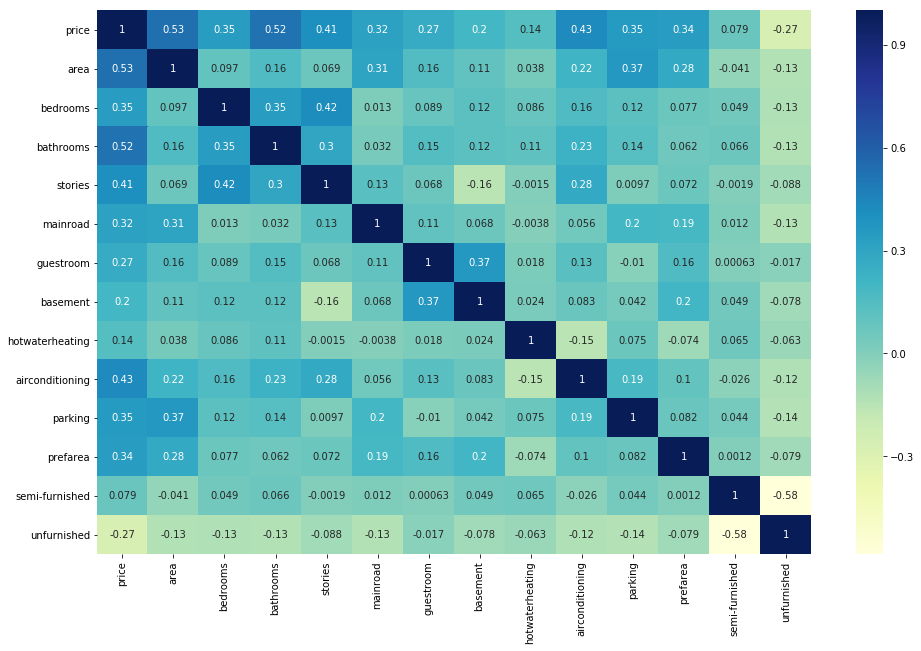

In [ ]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

As you might have noticed, `area` seems to the correlated to `price` the most. Let's see a pairplot for `area` vs `price`.

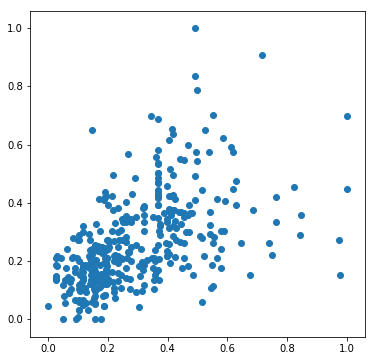

In [ ]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.area, df_train.price)
plt.show()

So, we pick `area` as the first variable and we'll try to fit a regression line to that.

### Dividing into X and Y sets for the model building

In [ ]:
y_train = df_train.pop('price')
X_train = df_train

## Step 5: Building a linear model

Fit a regression line through the training data using `statsmodels`. Remember that in `statsmodels`, you need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

In [ ]:
import statsmodels.api as sm

# Add a constant
X_train_lm = sm.add_constant(X_train[['area']])

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

In [ ]:
# Check the parameters obtained

lr.params

const    0.126894
area     0.462192
dtype: float64

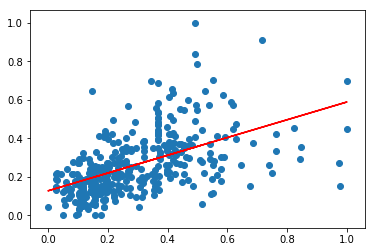

In [ ]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(X_train_lm.iloc[:, 1], y_train)
plt.plot(X_train_lm.iloc[:, 1], 0.127 + 0.462*X_train_lm.iloc[:, 1], 'r')
plt.show()

In [ ]:
# Print a summary of the linear regression model obtained
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.15e-29
Time:                        13:02:46   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.0

### Adding another variable

The R-squared value obtained is `0.283`. Since we have so many variables, we can clearly do better than this. So let's go ahead and add the second most highly correlated variable, i.e. `bathrooms`.

In [ ]:
# Assign all the feature variables to X
X_train_lm = X_train[['area', 'bathrooms']]

In [ ]:
# Build a linear model

import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params

const        0.104589
area         0.398396
bathrooms    0.298374
dtype: float64

In [ ]:
# Check the summary
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           2.51e-54
Time:                        13:02:47   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.0

We have clearly improved the model as the value of adjusted R-squared as its value has gone up to `0.477` from `0.281`.
Let's go ahead and add another variable, `bedrooms`.

In [ ]:
# Assign all the feature variables to X
X_train_lm = X_train[['area', 'bathrooms','bedrooms']]

In [ ]:
# Build a linear model

import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params

const        0.041352
area         0.392211
bathrooms    0.259978
bedrooms     0.181863
dtype: float64

In [ ]:
# Print the summary of the model

print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.12e-57
Time:                        13:02:47   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.0

We have improved the adjusted R-squared again. Now let's go ahead and add all the feature variables.

### Adding all the variables to the model

In [ ]:
# Check all the columns of the dataframe

housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished'],
      dtype='object')

In [ ]:
#Build a linear model

import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lm).fit()

lr_1.params

const              0.020033
area               0.234664
bedrooms           0.046735
bathrooms          0.190823
stories            0.108516
mainroad           0.050441
guestroom          0.030428
basement           0.021595
hotwaterheating    0.084863
airconditioning    0.066881
parking            0.060735
prefarea           0.059428
semi-furnished     0.000921
unfurnished       -0.031006
dtype: float64

In [ ]:
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           8.83e-83
Time:                        13:02:47   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021     

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

Maybe we could drop some?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [ ]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,bedrooms,7.33
4,mainroad,6.02
0,area,4.67
3,stories,2.70
11,semi-furnished,2.19
9,parking,2.12
6,basement,2.02
12,unfurnished,1.82
8,airconditioning,1.77
2,bathrooms,1.67


We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

### Dropping the variable and updating the model

As you can see from the summary and the VIF dataframe, some variables are still insignificant. One of these variables is, `semi-furnished` as it has a very high p-value of `0.938`. Let's go ahead and drop this variables

In [ ]:
# Dropping highly correlated variables and insignificant variables

X = X_train.drop('semi-furnished', 1,)

In [ ]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()

In [ ]:
# Print the summary of the model
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           1.07e-83
Time:                        13:02:48   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019     

In [ ]:
# Calculate the VIFs again for the new model

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

As you might have noticed, the variable `bedroom` has a significantly high VIF (`6.6`) and a high p-value (`0.206`) as well. Hence, this variable isn't of much use and should be dropped.

In [ ]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('bedrooms', 1)

In [ ]:
# Build a second fitted model
X_train_lm = sm.add_constant(X)

lr_3 = sm.OLS(y_train, X_train_lm).fit()

In [ ]:
# Print the summary of the model

print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           2.73e-84
Time:                        13:02:48   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015     

In [ ]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


### Dropping the variable and updating the model

As you might have noticed, dropping `semi-furnised` decreased the VIF of `mainroad` as well such that it is now under 5. But from the summary, we can still see some of them have a high p-value. `basement` for instance, has a p-value of 0.03. We should drop this variable as well.

In [ ]:
X = X.drop('basement', 1)

In [ ]:
# Build a fourth fitted model
X_train_lm = sm.add_constant(X)

lr_4 = sm.OLS(y_train, X_train_lm).fit()

In [ ]:
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     77.18
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.13e-84
Time:                        13:02:49   Log-Likelihood:                 378.51
No. Observations:                 381   AIC:                            -735.0
Df Residuals:                     370   BIC:                            -691.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0428      0.014     

In [ ]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,mainroad,4.55
0,area,4.54
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
9,unfurnished,1.33
4,guestroom,1.30
5,hotwaterheating,1.12


Now as you can see, the VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.

## Step 7: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [ ]:
y_train_price = lr_4.predict(X_train_lm)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Errors')

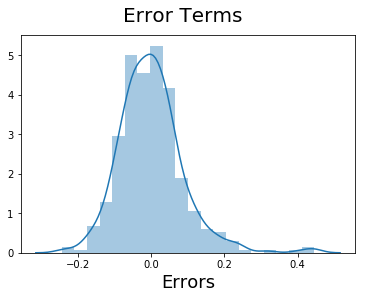

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Step 8: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [ ]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [ ]:
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X_test and y_test

In [ ]:
y_test = df_test.pop('price')
X_test = df_test

In [ ]:
# Adding constant variable to test dataframe
X_test_m4 = sm.add_constant(X_test)

In [ ]:
# Creating X_test_m4 dataframe by dropping variables from X_test_m4

X_test_m4 = X_test_m4.drop(["bedrooms", "semi-furnished", "basement"], axis = 1)

In [ ]:
# Making predictions using the fourth model

y_pred_m4 = lr_4.predict(X_test_m4)

## Step 9: Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0,0.5,'y_pred')

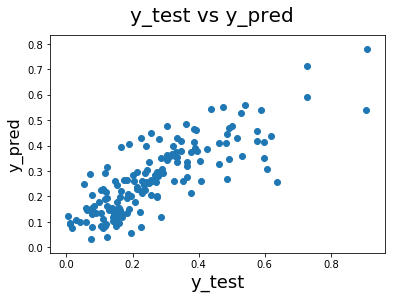

In [ ]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_m4)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      


We can see that the equation of our best fitted line is:

$ price = 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $


Overall we have a decent model, but we also acknowledge that we could do better. 

We have a couple of options:
1. Add new features (bathrooms/bedrooms, area/stories, etc.)
2. Build a non-linear model